In [1]:
import torch
from torch import nn
from torch.utils import data
import numpy as np
import torchvision
from torchvision import transforms


from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
from IPython import display
import time

In [2]:
resize=96
batch_size=128

In [3]:
trans = [transforms.Resize(resize),transforms.ToTensor()]
trans = transforms.Compose(trans)

# get the dataset
mnist_train = torchvision.datasets.FashionMNIST(
    "./data", train=True, transform=trans, target_transform=None, download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    "./data", train=False, transform=trans, target_transform=None, download=True
)

# dataLoader
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4)
test_iter = data.DataLoader(
    mnist_test, batch_size, shuffle=False, num_workers=4
)  # 测试集不用打乱

In [4]:
# 累加器
class Accumulator:
    def __init__(self, n) -> None:
        self.data = [0.0] * n
    def add(self,*args):
        self.data=[a+float(b)for a,b in zip(self.data,args)]
    def reset(self):
        self.data=[0.0]*len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]
    
# timer 计时器
class Timer:
    def __init__(self) -> None:
        self.times=[]
        self.start()
    def start(self):
        self.tik=time.time()
    def stop(self):
        self.times.append(time.time()-self.tik)
        return self.times[-1]
    def avg(self):
        return sum(self.times)/len(self.times)
    def sum(self):
        return sum(self.times)
    def cumsum(self):
        return np.array(self.times).cumsum.tolist()

In [5]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)#设置标签
    axes.set_xscale(xscale), axes.set_yscale(yscale)#设置刻度缩放
    axes.set_xlim(xlim),     axes.set_ylim(ylim)#设置显示范围
    if legend:
        axes.legend(legend)#设置图例
    axes.grid()#打开网格显示

In [6]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)#生成子图，1行1列
        if nrows * ncols == 1:
            self.axes = [self.axes,]
            #如果只有一个子图，就包装成列表
        self.X, self.Y, self.fmts = None, None, fmts
        # fmts是图形格式
        self.xlabel=xlabel
        self.ylabel=ylabel
        self.xscale=xscale
        self.yscale=yscale
        self.xlim=xlim
        self.ylim=ylim
        self.legend=legend

    def set_axes(self):
        self.axes[0].set_xlabel(self.xlabel), self.axes[0].set_ylabel(self.ylabel)
        self.axes[0].set_xscale(self.xscale), self.axes[0].set_yscale(self.yscale)
        self.axes[0].set_xlim(self.xlim),     self.axes[0].set_ylim(self.ylim)
        if self.legend:
            self.axes[0].legend(self.legend)
        self.axes[0].grid()
        
    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]#如果y不是可迭代的，将其包装成列表
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:#在最开始执行一次
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.set_axes()
        display.display(self.fig)# 在Jupyter环境中显示图形
        display.clear_output(wait=True)# 清除当前输出，实现动画效果

In [7]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(dim=1)  # 每个y_hat有10个结果，选其中最大的下标
    cmp = y_hat.type(dtype=y.dtype) == y  # True or False的tensor列表
    return float(sum(cmp.type(dtype=y.dtype)))


def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
            # 如果没有提供device，就是用net的第一层的device
    result = {"accuracy": 0, "size": 0}
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            result["accuracy"] += accuracy(net(X), y)
            result["size"] += torch.numel(y)
    return result["accuracy"] / result["size"]


# use GPU
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    return torch.device("cpu")


# initate weights
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

In [8]:
# # AlexNet
# net=nn.Sequential(
#     nn.Conv2d(1,96,kernel_size=11,stride=4,padding=1),nn.ReLU(),
#     nn.MaxPool2d(kernel_size=3,stride=2),
#     nn.Conv2d(96,256,kernel_size=5,padding=2),nn.ReLU(),
#     nn.MaxPool2d(kernel_size=3,stride=2),
#     nn.Conv2d(256,384,kernel_size=3,padding=1),nn.ReLU(),
#     nn.Conv2d(384,384,kernel_size=3,padding=1),nn.ReLU(),
#     nn.Conv2d(384,256,kernel_size=3,padding=1),nn.ReLU(),
#     nn.MaxPool2d(kernel_size=3,stride=2),
#     nn.Flatten(),
#     nn.Linear(6400,4096),nn.ReLU(),
#     nn.Dropout(p=0.5),
#     nn.Linear(4096,4096),nn.ReLU(),
#     nn.Dropout(p=0.5),
#     nn.Linear(4096,10)    
# )

In [9]:
# # VGG
# def vgg_block(num_convs,in_channels,out_channels):
#     layers=[]
#     for _ in range(num_convs):
#         layers.append(nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
#                                 kernel_size=3,padding=1))
#         layers.append(nn.ReLU())
#         in_channels=out_channels
#     layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
#     return nn.Sequential(*layers)

# def vgg(conv_arch):
#     print('running on VGG')
#     conv_blks=[]
#     in_channels=1
#     for (num_convs,out_channels) in conv_arch:
#         conv_blks.append(vgg_block(num_convs,in_channels,out_channels))
#         in_channels=out_channels
#     return nn.Sequential(
#         *conv_blks,nn.Flatten(),
#         nn.Linear(out_channels*7*7,4096), nn.ReLU(), nn.Dropout(0.5),
#         nn.Linear(4096,4096),nn.Dropout(0.5),
#         nn.Linear(4096,10)
#     )

# conv_arch=((1,64),(1,128),(2,256),(2,512),(2,512))
# net= vgg(conv_arch)

In [10]:
# # NiN
# def nin_block(in_channels,out_channels,kernel_size,stride,padding):
#     return nn.Sequential(
#         nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
#         nn.ReLU(),
#         nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU(),
#         nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU()
#     )
# def nin():
#     return nn.Sequential(
#         nin_block(1, 96, kernel_size=11, stride=4, padding=0),
#         nn.MaxPool2d(kernel_size=3, stride=2),
#         nin_block(96, 256, kernel_size=5, stride=1, padding=2),
#         nn.MaxPool2d(kernel_size=3, stride=2),
#         nin_block(256, 384, kernel_size=3, stride=1, padding=1),
#         nn.MaxPool2d(kernel_size=3, stride=2),
#         nn.Dropout(0.5),
#         nin_block(384, 10, kernel_size=3, strides=1, padding=1),
#         nn.AdaptiveAvgPool2d((1, 1)),
#         nn.Flatten(),
#     )


# net = nin()

In [11]:
# GoogleNet
from torch.nn import functional as F
class inception_block(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4):
        super(inception_block,self).__init__()
        self.p1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2 = nn.Sequential(
            nn.Conv2d(in_channels, c2[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1),
        )
        self.p3 = nn.Sequential(
            nn.Conv2d(in_channels, c3[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2),
        )
        self.p4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=1, padding=1),
            nn.Conv2d(in_channels, c4, kernel_size=1),
        )

    def forward(self,x):
        p1=F.relu(self.p1(x))
        p2=F.relu(self.p2(x))
        p3=F.relu(self.p3(x))
        p4=F.relu(self.p4(x))
        return torch.cat((p1,p2,p3,p4),dim=1)


b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)
b3 = nn.Sequential(
    inception_block(192, 64, (96, 128), (16, 32), 32),
    inception_block(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)
b4 = nn.Sequential(
    inception_block(480, 192, (96, 208), (16, 48), 64),
    inception_block(512, 160, (112, 224), (24, 64), 64),
    inception_block(512, 128, (128, 256), (24, 64), 64),
    inception_block(512, 112, (144, 288), (32, 64), 64),
    inception_block(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)
b5 = nn.Sequential(
    inception_block(832, 256, (160, 320), (32, 128), 128),
    inception_block(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
)

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [12]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

# net(X)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 192, 28, 28])
Sequential output shape:	 torch.Size([1, 480, 14, 14])
Sequential output shape:	 torch.Size([1, 832, 7, 7])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.242, train acc 0.908, test acc 0.893
1153.3 examples/sec on cuda:0


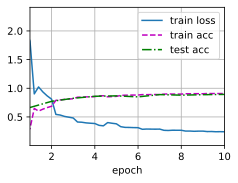

In [13]:
lr, num_epochs = 0.1, 10
device = try_gpu()
print(f"training on {device}")

net.apply(init_weights)
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()
animator = Animator(
    xlabel="epoch", xlim=[1, num_epochs], legend=["train loss", "train acc", "test acc"]
)
timer, num_batches = Timer(), len(train_iter)

# train
for epoch in range(num_epochs):
    metric = Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
        timer.start()
        optimizer.zero_grad()  # 清零梯度
        X, y = X.to(device), y.to(device)  # 转到GPU
        y_hat = net(X)  # 模型计算
        l = loss(y_hat, y)  # 计算损失
        l.backward()  # 反向传播，计算梯度
        optimizer.step()  # 利用计算的梯度更新参数
        with torch.no_grad():
            metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
        timer.stop()
        train_loss = metric[0] / metric[2]
        train_acc = metric[1] / metric[2]
        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (train_loss, train_acc, None))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
print(f"loss {train_loss:.3f}, train acc {train_acc:.3f}, " f"test acc {test_acc:.3f}")
print(f"{metric[2] * num_epochs / timer.sum():.1f} examples/sec " f"on {str(device)}")

In [26]:
# resnet
class residual_block(nn.Module):
    def __init__(
        self, in_channels, out_channels, use_1x1conv=False, stride=1, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1, stride=stride
        )
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(
                in_channels, out_channels, kernel_size=1, stride=stride
            )
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        y = self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))
        if self.conv3:
            y += self.conv3(x)
        return F.relu(y)


def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(
                residual_block(in_channels, out_channels, use_1x1conv=True, stride=2)
            )
        else:
            blk.append(residual_block(out_channels, out_channels))
    return blk


b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
net = nn.Sequential(
    b1, b2,b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10)
)

In [27]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])
